# Robustness Evaluation with Security Curves

This notebook demonstrates how to use the ART evaluations module for generating Security Curves. Security Curves have been widely used in the literature to determine and compare the robustness of machine learning models against adversarial examples [1, 2], as well as to identify shortcomings of defences - gradient masking in particular - which could be exploited by an adaptive adversary [3]. Essentially, Security Curves convey the performance of a given model under increasing attack perturbation budgets - commonly in terms of an l_p norm.

[1] A. Madry et al.: Towards Machine Learning Models Resistant to Adversarial Attacks. https://arxiv.org/abs/1706.06083
<br>
[2] Y. Dong et al.: Benchmarking Adversarial Robustness on Image Classification. https://arxiv.org/abs/1912.11852
<br>
[3] N. Carlini et al.: On Evaluating Adversarial Robustness. https://arxiv.org/abs/1902.06705

In [1]:
import torch
from keras.models import load_model

from robustness.datasets import CIFAR
from robustness.model_utils import make_and_restore_model

import numpy as np

from art.config import ART_DATA_PATH
from art.utils import load_dataset, get_file
from art.evaluations.security_curve import SecurityCurve

from art.estimators.classification import PyTorchClassifier, KerasClassifier

Using TensorFlow backend.


# Evaluate robust classifier trained with adversarial training

In [2]:
# Load CIFAR-10 dataset
(x_train_cifar, y_train_cifar), (x_test_cifar, y_test_cifar), min_cifar, max_cifar = load_dataset("cifar10")

In [3]:
# Change format frm NHWC to NCHW for PyTorch
x_train_cifar = np.transpose(x_train_cifar, (0, 3, 1, 2)).astype(np.float32)
x_test_cifar = np.transpose(x_test_cifar, (0, 3, 1, 2)).astype(np.float32)

In [4]:
# Define argument for PGD attack used in evaluation, except `classifier` and `eps`
kwargs_pgd = {"norm": "inf",
              "eps_step": 1/255,
              "max_iter": 100,
              "targeted": False,
              "num_random_init": 0,
              "batch_size": 128,
              "random_eps": False,
              "verbose": False,
             }

In [5]:
# Define attack budgets for evaluation as a list of floats
eps = [i / 255 for i in range(1, 32, 2)]

In [6]:
# Create an instance of a Security Curve evaluation
sc = SecurityCurve(eps=eps)

In [7]:
# Load a robust PyTorch model using the package `robustness` (https://github.com/MadryLab/robustness)
path_to_cifar10_data = "/tmp/data/"
resume_path = "/tmp/cifar_linf_8.pt"

ds = CIFAR(path_to_cifar10_data)
m, _ = make_and_restore_model(arch='resnet50',
                              dataset=ds,
                              resume_path=resume_path,
                             )

=> loading checkpoint '/tmp/cifar_linf_8.pt'
=> loaded checkpoint '/tmp/cifar_linf_8.pt' (epoch 153)


In [8]:
# Define mean and standard-deviation for preprocessing of the PyTorch model
mean=np.asarray([0.4914, 0.4822, 0.4465]).reshape(3, 1, 1).astype(np.float32)
std=np.asarray([0.2023,  0.1994, 0.2010]).reshape(3, 1, 1).astype(np.float32)

In [9]:
# Create an ART estimator for the PyTorch classification model
robust_classifier_cifar = PyTorchClassifier(model=m.model, 
                                            clip_values=(min_cifar, max_cifar),
                                            loss=torch.nn.CrossEntropyLoss(),
                                            input_shape=(3, 32, 32),
                                            nb_classes=10,
                                            preprocessing=(mean, std))

In [10]:
# Evaluate Security Curve for robust PyTorch classifier on CIFAR-10 on the first 100 samples
eps_list, accuracy_adv_list, accuracy = sc.evaluate(classifier=robust_classifier_cifar,
                                                    x=x_train_cifar[0:100],
                                                    y=y_train_cifar[0:100],
                                                    **kwargs_pgd)

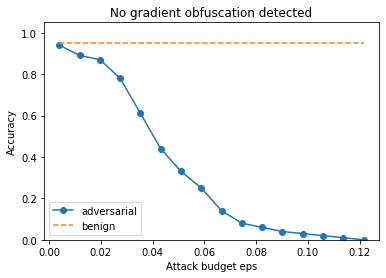

In [11]:
# Plot the Security Curve for the evaluation of the robust PyTorch classifier on CIFAR-10
sc.plot()

In [12]:
# Check if the robust PyTorch classifier is potentially obfuscating loss gradients
sc.detected_obfuscating_gradients

False

# Robust Classifier with Gradient Obfuscation by Vanishing Gradients

In [13]:
# Load MNIST dataset
(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist), min_mnist, max_mnist = load_dataset('mnist')

In [14]:
# Load a robust Keras model with potential gradient obfuscation caused by vanishing gradients.
path = get_file('mnist_cnn_robust.h5', extract=False, path=ART_DATA_PATH,
                url='https://www.dropbox.com/s/yutsncaniiy5uy8/mnist_cnn_robust.h5?dl=1')
robust_classifier_model = load_model(path)
robust_classifier_mnist = KerasClassifier(clip_values=(min_mnist, max_mnist),
                                          model=robust_classifier_model,
                                          use_logits=False)

In [15]:
# Define argument for PGD attack used in evaluation, except `classifier` and `eps`
kwargs_pgd = {"norm": "inf",
              "eps_step": 1/255,
              "max_iter": 100,
              "targeted": False,
              "num_random_init": 0,
              "batch_size": 128,
              "random_eps": False,
              "verbose": False,
             }

In [16]:
# Define attack budgets for evaluation as number of evaluations equally spaced between minimal and 
# maximal `eps`.
eps = 64

In [17]:
# Create an instance of a Security Curve evaluation
sc = SecurityCurve(eps=eps)

In [18]:
# Evaluate Security Curve for robust PyTorch classifier on CIFAR-10 on the first 100 samples
eps_list, accuracy_adv_list, accuracy = sc.evaluate(classifier=robust_classifier_mnist,
                                                    x=x_train_mnist[0:100],
                                                    y=y_train_mnist[0:100],
                                                    **kwargs_pgd)

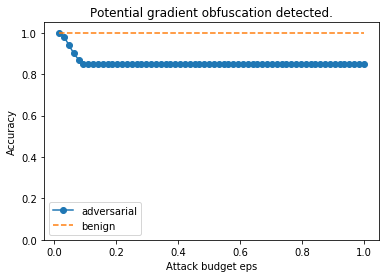

In [19]:
# Plot the Security Curve for the evaluation of the robust PyTorch classifier on CIFAR-10
sc.plot()

In [20]:
# Check if the robust PyTorch classifier is potentially obfuscating loss gradients
sc.detected_obfuscating_gradients

True